# Continuation Of Previous Notebook

Ecperimaentation with LightGBM

In [228]:
##pip install lightgbm

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

In [230]:
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [231]:
train_data = pd.read_csv('./demand-forecasting-kernels-only/train.csv')

In [232]:
train_data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [233]:
train_data['date'] = pd.to_datetime(train_data['date'], format = '%Y-%m-%d')
train_data.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [234]:
train_data.groupby(['store','item']).agg({"sales":["sum", "mean", "median","std"]})

sales                             
               sum       mean median        std
store item                                     
1     1      36468  19.971522   19.0   6.741022
      2      97050  53.148959   52.0  15.005779
      3      60638  33.208105   33.0  10.072529
      4      36440  19.956188   20.0   6.640618
      5      30335  16.612815   16.0   5.672102
...            ...        ...    ...        ...
10    46    120601  66.046550   65.0  18.114991
      47     45204  24.755750   24.0   7.924820
      48    105570  57.814896   57.0  15.898538
      49     60317  33.032311   32.0  10.091610
      50    135192  74.037240   73.0  19.937566

[500 rows x 4 columns]

### Feature Engineering

#### Time Features

In [235]:
train_data['year'] = train_data['date'].dt.year
train_data['month'] = train_data['date'].dt.month
train_data['day'] = train_data['date'].dt.day
train_data['weekday'] = train_data['date'].dt.weekday

train_data['week_of_year'] = train_data['date'].dt.weekofyear
train_data['is_weekend'] = train_data['date'].dt.weekday//4
train_data['is_month_start'] = train_data['date'].dt.is_month_start.astype(int)
train_data['is_month_end'] = train_data['date'].dt.is_month_end.astype(int) 

In [236]:
train_data.sort_values(by=['store','item','date'], axis = 0, inplace=True)

#### Lag & Shifting

In [237]:
def lagFeatures(data, lags):
    for lag in lags:
        data['sales_lag_'+ str(lag)] = data.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag)) + np.random.normal(scale=1.6, size=(len(data),))
    return data

In [238]:
train_data = lagFeatures(train_data, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

#### Rolling Mean

In [239]:
def rollMeanFeatures(data, windows):
    for win in windows:
        data['sales_rollMean_'+ str(win)] = data.groupby(['store','item'])['sales'].transform(lambda x:x.shift(1).rolling(window=win).mean())+ np.random.normal(scale=1.6, size=(len(data),))
    return data

In [240]:
train_data = rollMeanFeatures(train_data,[365,540,730]) # one year, 18 months and 2 years

- 'Store' and 'Item' columns should be considered as Categorical columns with NO order. Although this adds a lot of features but it is helpful for the GradientBoosting algorithm to generalize better.

In [241]:
train_data_ = pd.get_dummies(train_data, columns =  ['month', 'weekday','store','item'])

In [242]:
train_data_.shape

(913000, 100)

### Box Plot Of 'Sales' Column

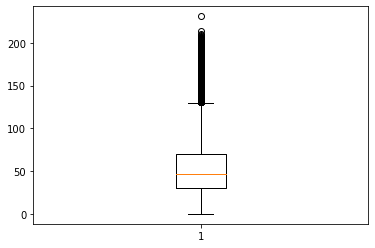

In [243]:
plt.boxplot(train_data['sales'])
plt.show()

#### Box Plot of log(1+p) Of Sales Column

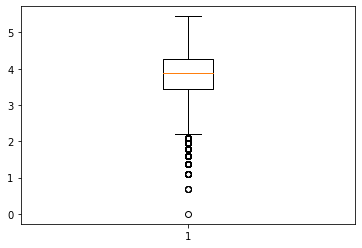

In [244]:
plt.boxplot(np.log1p(train_data['sales'].values))
plt.show()

- As clearly seen above that the actual values have outliers in sales. Doing a logarithm shift has reduced the outliers and should not hamper the prediction

In [245]:
train_data_['sales'] = np.log1p(train_data_['sales'].values)

In [246]:
train_data_['dateAsID'] = train_data_['date']
train_data_ = train_data_.set_index('dateAsID')
train_data_.head()

,date,sales,year,day,week_of_year,is_weekend,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_rollMean_365,sales_rollMean_540,sales_rollMean_730,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
dateAsID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,2013-01-01,2.639057,2013,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-02,2013-01-02,2.484907,2013,2,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-03,2013-01-03,2.708050,2013,3,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-04,2013-01-04,2.639057,2013,4,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-05,2013-01-05,2.397895,2013,5,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Train, Validation & Test Split

In [247]:
train = train_data_.loc[(train_data_['date']< '2017-03-1'),:] # training data until February 2017

val = train_data_.loc[(train_data_['date']>= '2017-03-1') & (train_data_['date']< '2017-09-1'),:] # 6 months for Validation

test = train_data_.loc[(train_data_['date']>= '2017-09-1'),:] # Last 4 months kept for Testing

In [248]:
# dropping the unnecessary columns

train_cols_ = [col for col in train_data_.columns if col not in ['date','sales', 'year','day']]


In [249]:
X_train = train[train_cols_]
Y_train = train['sales']

X_val = val[train_cols_]
Y_val = val['sales']

X_test = test[train_cols_]
Y_test = test['sales']

### Evaluation Function

In [250]:
def eval(y_true, y_pred):
    mape = np.mean(abs((y_pred-y_true)/y_true))*100
    smape = np.mean(abs(y_pred-y_true)*200/(np.abs(y_pred)+np.abs(y_true)).fillna(0))
    print('MAPE: %.2f \nSMAPE: %.2f'%(mape,smape),"%")

### Model Experiments

In [251]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=train_cols_)
lgbval = lgb.Dataset(data=X_val, label=Y_val,reference=lgbtrain, feature_name=train_cols_)

#### Experiment 1

In [252]:
lgb_params_1 = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200,
              'nthread': -1}

In [253]:
lgbmodel_exp1 = lgb.train(lgb_params_1, lgbtrain, valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params_1['num_boost_round'],
                  early_stopping_rounds=lgb_params_1['early_stopping_rounds'],
                  verbose_eval=100)

lgb_val_preds_exp1 = lgbmodel_exp1.predict(X_val,num_iteration=lgbmodel_exp1.best_iteration)
eval(np.expm1(Y_val), np.expm1(lgb_val_preds_exp1))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045583 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.193349	valid_1's l1: 0.16111
[200]	training's l1: 0.164983	valid_1's l1: 0.131948
[300]	training's l1: 0.15791	valid_1's l1: 0.128753
[400]	training's l1: 0.153552	valid_1's l1: 0.12731
[500]	training's l1: 0.150215	valid_1's l1: 0.125612
[600]	training's l1: 0.147501	valid_1's l1: 0.124135
[700]	training's l1: 0.145346	valid_1's l1: 0.122833
[800]	training's l1: 0.143538	valid_1's l1: 0.12181
[900]	training's l1: 0.141969	valid_1's l1: 0.120864
[1000]	training's l1: 0.140617	valid_1's l1: 0.120091
[1100]	training's l1: 0.139394	valid_1's l1: 0.119393
[1200]	training's l1: 0.13832	valid_1's l1: 0.118736
[1300]	training's l1: 0.137334	valid_1's l1: 0.118176
[1400]	training's l1: 0.13648	valid_1's l1: 0.117666
[1500]	training's l1: 0.135733	v

In [254]:
print("#### Experiment 1 : Evaluation On Test Set ####")
lgb_test_preds = lgbmodel.predict(X_test,num_iteration=lgbmodel.best_iteration)
eval(np.expm1(Y_test), np.expm1(lgb_test_preds))

#### Experiment 1 : Evaluation On Test Set ####
MAPE: 12.41 
SMAPE: 12.12 %


#### Experimet 2

In [255]:
lgb_params_2 = {'boosting_type':{'gbdt'},
              'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.01,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200,
              'nthread': -1}

In [256]:
lgbmodel_exp2 = lgb.train(lgb_params_2, lgbtrain, valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params_2['num_boost_round'],
                  early_stopping_rounds=lgb_params_2['early_stopping_rounds'],
                  verbose_eval=100)

lgb_val_preds_exp2 = lgbmodel_exp2.predict(X_val,num_iteration=lgbmodel_exp2.best_iteration)
eval(np.expm1(Y_val), np.expm1(lgb_val_preds_exp2))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058270 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.258353	valid_1's l1: 0.240837
[200]	training's l1: 0.19379	valid_1's l1: 0.160884
[300]	training's l1: 0.173311	valid_1's l1: 0.138822
[400]	training's l1: 0.165145	valid_1's l1: 0.132378
[500]	training's l1: 0.16077	valid_1's l1: 0.130092
[600]	training's l1: 0.15797	valid_1's l1: 0.128964
[700]	training's l1: 0.155627	valid_1's l1: 0.128018
[800]	training's l1: 0.153621	valid_1's l1: 0.12732
[900]	training's l1: 0.151898	valid_1's l1: 0.126568
[1000]	training's l1: 0.15032	valid_1's l1: 0.125672
[1100]	training's l1: 0.148818	valid_1's l1: 0.124915
[1200]	training's l1: 0.147536	valid_1's l1: 0.124201
[1300]	training's l1: 0.146382	valid_1's l1: 0.123543
[1400]	training's l1: 0.145386	valid_1's l1: 0.122905
[1500]	training's l1: 0.144422	

In [257]:
print("#### Experiment 2 : Evaluation On Test Set####")
lgb_test_preds_exp2 = lgbmodel_exp2.predict(X_test,num_iteration=lgbmodel_exp2.best_iteration)
eval(np.expm1(Y_test), np.expm1(lgb_test_preds_exp2))

#### Experiment 2 : Evaluation On Test Set####
MAPE: 12.60 
SMAPE: 12.25 %


#### Experiment 3

In [258]:
lgb_params_3 = {'boosting_type':{'dart'},
              'metric': {'mae'},
              'num_leaves': 20,
              'learning_rate': 0.01,
              #'feature_fraction': 0.8,
              'max_depth': 10,
              'verbose': 0,
              'num_boost_round': 5000, 
              #'early_stopping_rounds': 200,
              'nthread': -1}

In [259]:
lgbmodel_exp3 = lgb.train(lgb_params_3, lgbtrain, valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params_3['num_boost_round'],
                  #early_stopping_rounds=lgb_params_3['early_stopping_rounds'],
                  verbose_eval=100)

lgb_val_preds_exp3 = lgbmodel_exp3.predict(X_val,num_iteration=lgbmodel_exp3.best_iteration)
eval(np.expm1(Y_val), np.expm1(lgb_val_preds_exp3))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[100]	training's l1: 1.42058	valid_1's l1: 1.60691
[200]	training's l1: 1.62752	valid_1's l1: 1.77952
[300]	training's l1: 1.31962	valid_1's l1: 1.43808
[400]	training's l1: 1.05325	valid_1's l1: 1.14409
[500]	training's l1: 0.849303	valid_1's l1: 0.917475
[600]	training's l1: 0.809115	valid_1's l1: 0.87526
[700]	training's l1: 0.71341	valid_1's l1: 0.766709
[800]	training's l1: 0.67586	valid_1's l1: 0.724768
[900]	training's l1: 0.574797	valid_1's l1: 0.613443
[1000]	training's l1: 0.538504	valid_1's l1: 0.573601
[1100]	training's l1: 0.508555	valid_1's l1: 0.538828
[1200]	training's l1: 0.515279	valid_1's l1: 0.545905
[1300]	training's l1: 0.464295	valid_1's l1: 0.490759
[1400]	training's l1: 0.397536	valid_1's l1: 0.414709
[1500]	training's l1: 0.404231	vali

In [260]:
print("#### Experiment 3 : Evaluation On Test Set####")
lgb_test_preds_exp3 = lgbmodel_exp3.predict(X_test,num_iteration=lgbmodel_exp3.best_iteration)
eval(np.expm1(Y_test), np.expm1(lgb_test_preds_exp3))

#### Experiment 3 : Evaluation On Test Set####
MAPE: 14.46 
SMAPE: 15.32 %


#### Experiment 4

In [261]:
lgb_params_4 = {'boosting_type':{'goss'},
              'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200,
              'nthread': -1}

In [262]:
lgbmodel_exp4 = lgb.train(lgb_params_4, lgbtrain, valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params_4['num_boost_round'],
                  early_stopping_rounds=lgb_params_4['early_stopping_rounds'],
                  verbose_eval=100)

lgb_val_preds_exp4 = lgbmodel_exp4.predict(X_val,num_iteration=lgbmodel_exp4.best_iteration)
eval(np.expm1(Y_val), np.expm1(lgb_val_preds_exp4))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117153 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.193282	valid_1's l1: 0.161396
[200]	training's l1: 0.165076	valid_1's l1: 0.13233
[300]	training's l1: 0.157999	valid_1's l1: 0.128917
[400]	training's l1: 0.153538	valid_1's l1: 0.127167
[500]	training's l1: 0.150153	valid_1's l1: 0.125413
[600]	training's l1: 0.14742	valid_1's l1: 0.124078
[700]	training's l1: 0.145202	valid_1's l1: 0.122729
[800]	training's l1: 0.14334	valid_1's l1: 0.121663
[900]	training's l1: 0.141712	valid_1's l1: 0.120695
[1000]	training's l1: 0.140335	valid_1's l1: 0.11992
[1100]	training's l1: 0.139102	valid_1's l1: 0.119158
[1200]	training's l1: 0.137982	valid_1's l1: 0.118578
[1300]	training's l1: 0.137	valid_1's l1: 0.117953
[1400]	training's l1: 0.136177	valid_1's l1: 0.117422
[1500]	training's l1: 0.135433	va

In [263]:
print("#### Experiment 4 : Evaluation On Test Set####")
lgb_test_preds_exp4 = lgbmodel_exp4.predict(X_test,num_iteration=lgbmodel_exp4.best_iteration)
eval(np.expm1(Y_test), np.expm1(lgb_test_preds_exp4))

#### Experiment 4 : Evaluation On Test Set####
MAPE: 12.42 
SMAPE: 12.13 %


### Best Model

From the above experiments, it is evident that the parameter set number 4 had the best performance on the test set. We choose the 'GOSS' boosting type and train the model on both Train & Validation Set and have a final prediction on the last three months

In [264]:
final_train = train_data_.loc[train_data_['date']< '2017-09-1',:]
final_X_train = final_train[train_cols_]
final_Y_train = final_train['sales']
# Final Train Test Dataset

final_lgb_train = lgb.Dataset(data=X_train, label=Y_train, feature_name=train_cols_)



In [265]:
final_lgb_params = {'boosting_type':{'goss'},
              'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': lgbmodel_exp4.best_iteration, 
              'nthread': -1}

In [266]:
lgbmodel = lgb.train(final_lgb_params, final_lgb_train,
                  num_boost_round=final_lgb_params['num_boost_round'])

lgb_test_preds = lgbmodel.predict(X_test,num_iteration=lgbmodel_exp4.best_iteration)
eval(np.expm1(Y_test), np.expm1(lgb_test_preds))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
MAPE: 12.42 
SMAPE: 12.13 %


## Visualization

In [267]:
X_test.filter(regex=("store.*")).columns

Index(['store_1', 'store_2', 'store_3', 'store_4', 'store_5', 'store_6',
       'store_7', 'store_8', 'store_9', 'store_10'],
      dtype='object')

In [268]:
item_store_cols = ['item_1', 'item_2', 'item_3', 'item_4', 'item_5', 'item_6', 'item_7',
       'item_8', 'item_9', 'item_10', 'item_11', 'item_12', 'item_13',
       'item_14', 'item_15', 'item_16', 'item_17', 'item_18', 'item_19',
       'item_20', 'item_21', 'item_22', 'item_23', 'item_24', 'item_25',
       'item_26', 'item_27', 'item_28', 'item_29', 'item_30', 'item_31',
       'item_32', 'item_33', 'item_34', 'item_35', 'item_36', 'item_37',
       'item_38', 'item_39', 'item_40', 'item_41', 'item_42', 'item_43',
       'item_44', 'item_45', 'item_46', 'item_47', 'item_48', 'item_49',
       'item_50', 'store_1', 'store_2', 'store_3', 'store_4', 'store_5', 'store_6',
       'store_7', 'store_8', 'store_9', 'store_10']


In [269]:
# Forecast Vizualization

outputs = X_test[item_store_cols]
outputs['sales'] = np.round(np.expm1(Y_test),1)
outputs['forecast'] = np.round(np.expm1(lgb_test_preds),1)


In [270]:
start_date = '2017-10-01'
end_date = '2017-12-31'

In [271]:
# Visualization Of prediction On Last 3 months data

outputs_3month = outputs.loc[start_date:end_date]

### ['item_X'] & ['store_Y'] (For Tutor Evaluation)

The Item & Store numbers(X & Ys) from the below cells can be changed to visualize the forecasting performance on each store-product combinations 

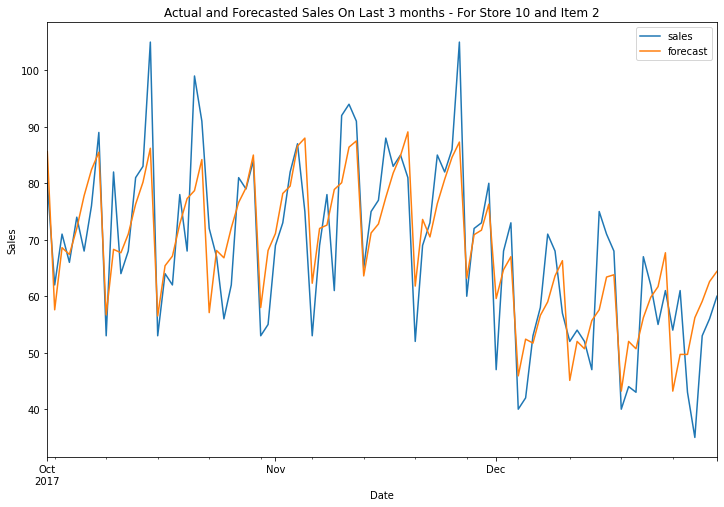

In [272]:
outputs_3month[(outputs_3month['item_2']==1) & (outputs_3month['store_10']==1)][['sales','forecast']].plot(figsize=(12, 8))
plt.title('Actual and Forecasted Sales On Last 3 months - For Store 10 and Item 2')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

### Feature Importance

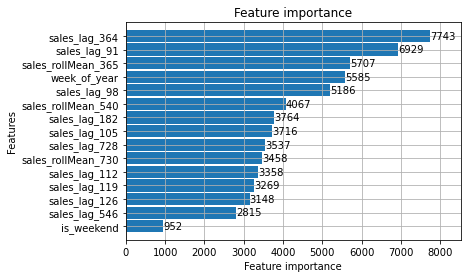

In [273]:
lgb.plot_importance(lgbmodel, max_num_features = 15, height=.9)
plt.show()

- Some of the features had very high importance such as Yearly sales lag, 90 days sales lag, Yearly rolling mean and week of the year. We also see that weekend feature has also some influence.

## Result Discussion

This Notebook is in continuation to the one where statustical models such as SARIMA(X) was applied. The main drawback using the classical method was that we eeded to train 500 models for each Store-Item combination for high forecasting accuracy. A general model was needed whihc could predict all the combinations with high accuracy.

- New features such as Weekends(Friday/Saturday/Sunday) were given high weights as sales in the weekends were generally higher.
- Various Time related features such as Time Lags/Shifts in sales and Rolling means were added to the original dataset.
- One hot encoding of Store-Item combination was done to capture more information. Feature Importance chart shows that top 15 important features are all engineered one
- One of the advantage compared with the SARIMA(X) model was that the LightGBM model it can predict on any of the store-item combination and that too with <b>MAPE of 12%</b> on the test set.
- <b>Drawback</b> for this model is that training and finding right hyper-parameters takes lot of time.